# Step 1: Upload the Dataset to Colab (if using Colab)

In [1]:

from google.colab import files
uploaded = files.upload()

Saving skin-disease-datasaet.zip to skin-disease-datasaet.zip



# Step 2: Import required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install tensorflow==2.12 keras==2.12

In [2]:
# Unzip the dataset
import zipfile
import os

with zipfile.ZipFile('skin-disease-datasaet.zip', 'r') as zip_ref:
    zip_ref.extractall('skin-disease-datasaet')

# Verify the dataset structure
dataset_dir = 'skin-disease-datasaet'
print(os.listdir(dataset_dir))

# Step 2: Define the base directory for the dataset
base_dir = 'skin-disease-datasaet/skin-disease-datasaet'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Function to count images in each class directory
def count_images(directory):
    return {subdir: len(os.listdir(os.path.join(directory, subdir))) for subdir in os.listdir(directory)}

print('Train set:', count_images(train_dir))
print('Validation set:', count_images(validation_dir))
print('Test set:', count_images(test_dir))

['skin-disease-datasaet']
Train set: {'FU-ringworm': 79, 'VI-chickenpox': 119, 'FU-athlete-foot': 109, 'FU-nail-fungus': 115, 'BA- cellulitis': 119, 'VI-shingles': 114, 'PA-cutaneous-larva-migrans': 87, 'BA-impetigo': 70}
Validation set: {'FU-ringworm': 17, 'VI-chickenpox': 25, 'FU-athlete-foot': 24, 'FU-nail-fungus': 25, 'BA- cellulitis': 25, 'VI-shingles': 24, 'PA-cutaneous-larva-migrans': 19, 'BA-impetigo': 15}
Test set: {'FU-ringworm': 17, 'VI-chickenpox': 26, 'FU-athlete-foot': 23, 'FU-nail-fungus': 22, 'BA- cellulitis': 26, 'VI-shingles': 25, 'PA-cutaneous-larva-migrans': 19, 'BA-impetigo': 15}


# Step 3: Load the DenseNet201 model pre-trained on ImageNet


In [3]:
from tensorflow.keras.applications import DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 4: Freeze the base model to prevent it from being trained


In [4]:
base_model.trainable = False

# Step 5: Add custom layers on top of DenseNet201

In [5]:
from tensorflow.keras.layers import BatchNormalization
num_classes = 8
for layer in base_model.layers[:250]:  # Freeze first 250 layers
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)  # Increase the number of units
x = Dropout(0.7)(x)  # Higher dropout rate to prevent overfitting
x = BatchNormalization()(x)  # Batch normalization layer
predictions = Dense(num_classes, activation='softmax')(x)

# Step 6: Build the model

In [6]:
model = Model(inputs=base_model.input, outputs=predictions)

# Step 7: Compile the model

In [7]:
from tensorflow.keras.metrics import AUC, Precision, Recall  # Import the metrics

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(), Precision(), Recall()]  # Include AUC, Precision, and Recall here
)


# Step 8: Display the model summary

In [10]:
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Step 9: Data Anotation and Data Preprocessing

In [12]:
import os
import pandas as pd
import logging
from PIL import Image  # For extracting image dimensions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set up logging
logging.basicConfig(filename='image_processing.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Define base directory for the dataset
base_dir = '/content/skin-disease-datasaet/skin-disease-datasaet'

# Subdirectories for dataset splits
splits = ['train', 'validation', 'test']

# Dictionary to store annotations
annotations = {split: [] for split in splits}

# Generate annotations with additional metadata
for split in splits:
    split_dir = os.path.join(base_dir, split)
    for disease_class in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, disease_class)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                try:
                    # Open image to get metadata
                    with Image.open(image_path) as img:
                        width, height = img.size  # Get dimensions
                        file_type = image_file.split('.')[-1]  # Extract file extension

                    # Append data with metadata
                    annotations[split].append({
                        'image_path': image_path,
                        'label': disease_class.strip(),
                        'width': width,
                        'height': height,
                        'file_type': file_type
                    })

                    logging.info(f"Processed image: {image_path}")

                except Exception as e:
                    logging.error(f"Error processing file {image_path}: {e}")

# Save annotations as CSV files
for split, data in annotations.items():
    df = pd.DataFrame(data)
    csv_path = f'{split}_annotations.csv'
    df.to_csv(csv_path, index=False)
    logging.info(f'{split.capitalize()} annotations saved to: {csv_path}')

    # Verify the saved CSV files
    try:
        # Load the CSV to verify its contents
        df_loaded = pd.read_csv(csv_path)
        logging.info(f'{split.capitalize()} CSV loaded successfully. First few rows:')
        logging.info(df_loaded.head())
    except Exception as e:
        logging.error(f"Error loading CSV file {csv_path}: {e}")

if os.path.exists('best_model.keras'):
    model = load_model('best_model.keras')  # Adjust path if needed
else:
    print("Model file 'best_model.keras' not found. Training the model first...")

# Data Augmentation for the training set (increased variety)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5]  # Random brightness adjustment
)

# No data augmentation for validation/test sets, just rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Apply class weights to handle class imbalance
class_weights = {0: 1., 1: 1., 2: 1., 3: 2., 4: 2., 5: 2., 6: 2., 7: 2.}  # Adjust based on your class distribution

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Model file 'best_model.keras' not found. Training the model first...
Found 810 images belonging to 8 classes.
Found 174 images belonging to 8 classes.
Found 173 images belonging to 8 classes.



# Step 10: Callbacks for saving the best model and early stopping

In [13]:
# Define callbacks for EarlyStopping and Learning Rate Scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)




# Step 11: Train the model

In [14]:

# Model training with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # Set your desired number of epochs
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, lr_scheduler]  # Include callbacks
)



Epoch 1/10
25/25 [==============================] - 208s 8s/step - loss: 3.6126 - accuracy: 0.2301 - auc: 0.6315 - precision: 0.2913 - recall: 0.0861 - val_loss: 1.4866 - val_accuracy: 0.5625 - val_auc: 0.8513 - val_precision: 1.0000 - val_recall: 0.0688 - lr: 1.0000e-04
Epoch 2/10
25/25 [==============================] - 178s 7s/step - loss: 2.2471 - accuracy: 0.5013 - auc: 0.8426 - precision: 0.6592 - recall: 0.3033 - val_loss: 1.0838 - val_accuracy: 0.7125 - val_auc: 0.9360 - val_precision: 0.9655 - val_recall: 0.3500 - lr: 1.0000e-04
Epoch 3/10
25/25 [==============================] - 178s 7s/step - loss: 1.7559 - accuracy: 0.5900 - auc: 0.9062 - precision: 0.7339 - recall: 0.4396 - val_loss: 0.8574 - val_accuracy: 0.7688 - val_auc: 0.9640 - val_precision: 0.9651 - val_recall: 0.5188 - lr: 1.0000e-04
Epoch 4/10
25/25 [==============================] - 193s 8s/step - loss: 1.4711 - accuracy: 0.6774 - auc: 0.9331 - precision: 0.7909 - recall: 0.5591 - val_loss: 0.7044 - val_accuracy:


# Step 12: Evaluate the model on validation data

In [15]:
# Evaluate the model on the validation set and unpack all returned metrics
val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(validation_generator)

# Print each metric for the validation set
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation AUC: {val_auc:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')

# Evaluate the model on the test set and unpack all returned metrics
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_generator)

# Print each metric for the test set
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')


6/6 [==============================] - 31s 5s/step - loss: 0.3456 - accuracy: 0.8851 - auc: 0.9935 - precision: 0.9490 - recall: 0.8563
Validation Loss: 0.3456
Validation Accuracy: 0.8851
Validation AUC: 0.9935
Validation Precision: 0.9490
Validation Recall: 0.8563
6/6 [==============================] - 32s 5s/step - loss: 0.2429 - accuracy: 0.9422 - auc: 0.9978 - precision: 0.9747 - recall: 0.8902
Test Loss: 0.2429
Test Accuracy: 0.9422
Test AUC: 0.9978
Test Precision: 0.9747
Test Recall: 0.8902


# Step 13: Save the final model

In [16]:
# Step 8: Classification Report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# Predict the classes for test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class indices for predictions

# Get the true labels from the test data generator
y_true = test_generator.classes

class_report = classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys()))
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix:\n', conf_matrix)


6/6 [==============================] - 35s 5s/step
                            precision    recall  f1-score   support

            BA- cellulitis       0.96      0.92      0.94        26
               BA-impetigo       1.00      1.00      1.00        15
           FU-athlete-foot       0.85      0.96      0.90        23
            FU-nail-fungus       0.96      1.00      0.98        22
               FU-ringworm       1.00      0.94      0.97        17
PA-cutaneous-larva-migrans       0.88      0.74      0.80        19
             VI-chickenpox       0.96      1.00      0.98        26
               VI-shingles       0.96      0.96      0.96        25

                  accuracy                           0.94       173
                 macro avg       0.95      0.94      0.94       173
              weighted avg       0.94      0.94      0.94       173

Confusion Matrix:
 [[24  0  0  0  0  1  1  0]
 [ 0 15  0  0  0  0  0  0]
 [ 0  0 22  0  0  1  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

# Print additional metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.9451
Recall: 0.9397
F1 Score: 0.9410


**SAVE MODEL**

In [18]:
model.save('best_model.keras.keras')

print("Training completed. Check the 'image_processing.log' for details.")


Training completed. Check the 'image_processing.log' for details.


In [20]:
from tensorflow.keras.models import load_model

# Load your custom trained DenseNet201 model
model = load_model('best_model.keras.keras')  # Update with your model path


# Step 14: Plot training history

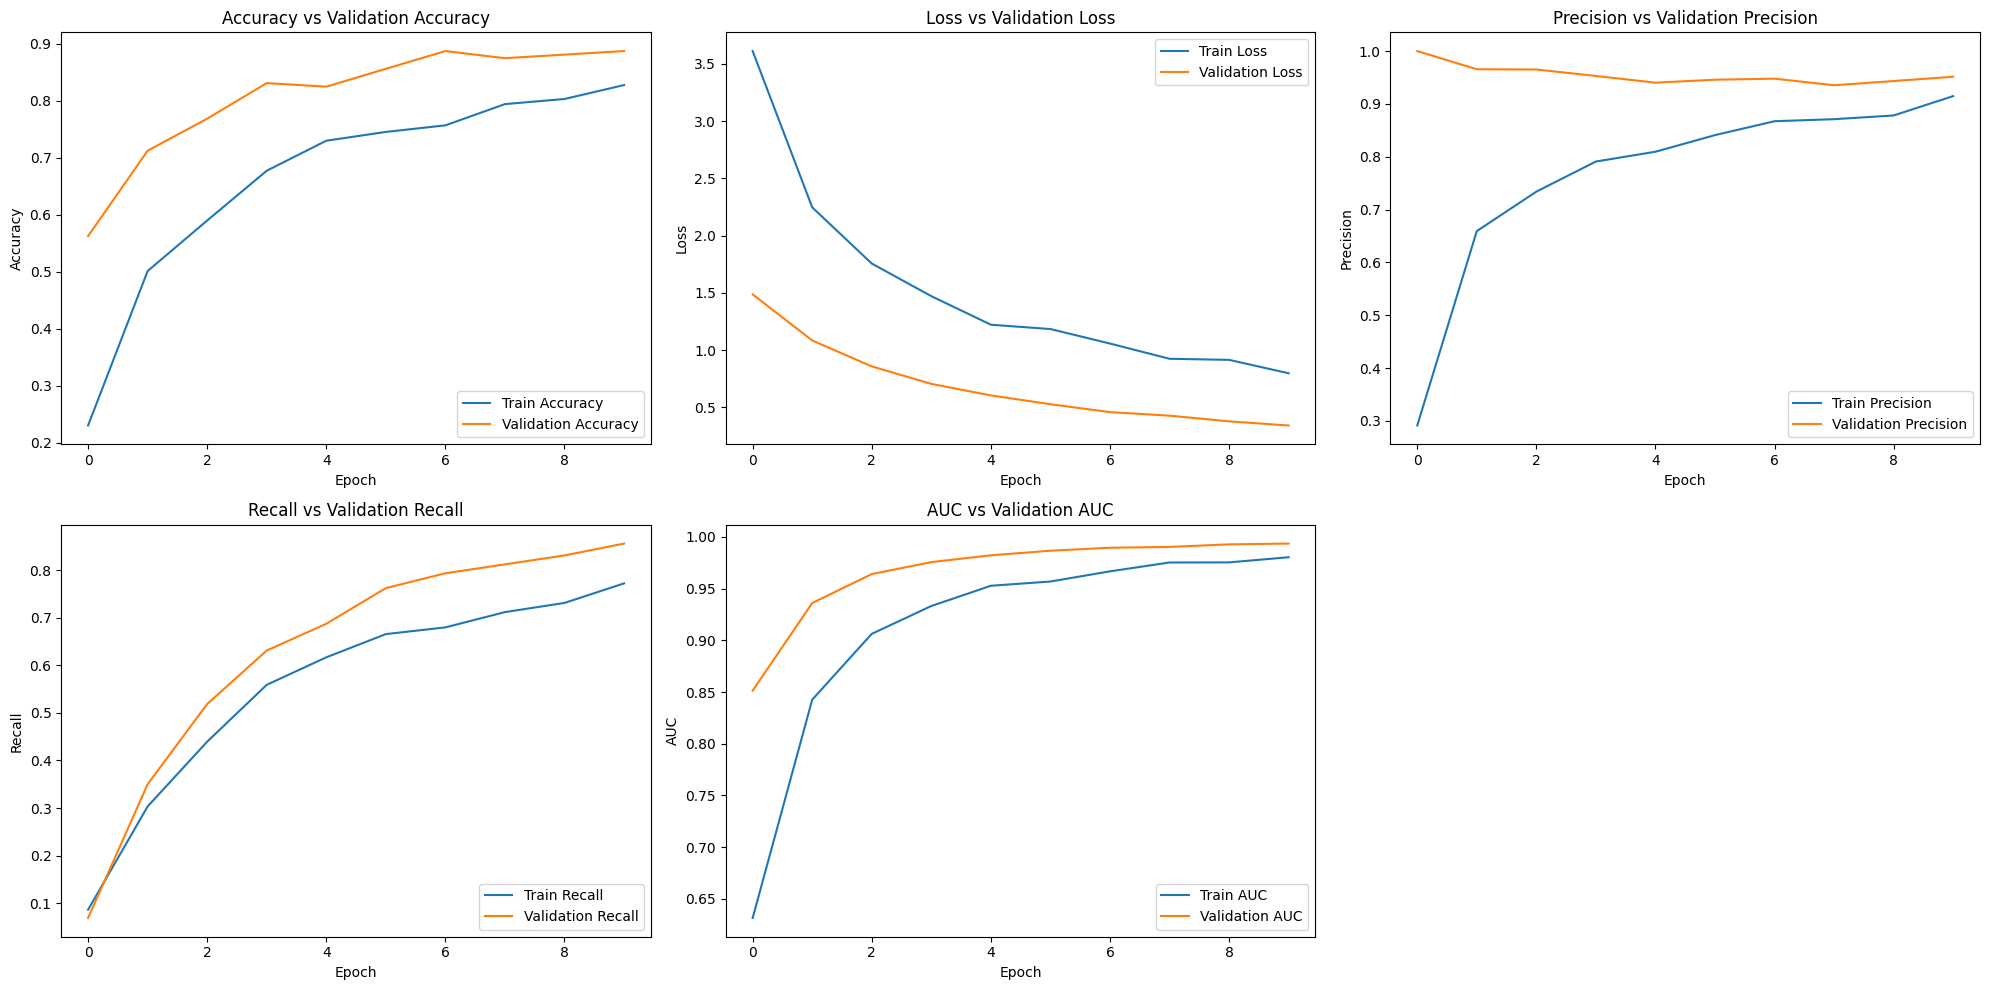

In [21]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(20, 10))

# Accuracy
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Precision
plt.subplot(2, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')

plt.title('Precision vs Validation Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Recall
plt.subplot(2, 3, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall vs Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# AUC
plt.subplot(2, 3, 5)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC vs Validation AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [22]:
# Step 11: Print total metrics summary
print(f'Train Loss: {history.history["loss"][-1]:.4f}')  # Last epoch train loss
print(f'Train Accuracy: {history.history["accuracy"][-1]:.4f}')  # Last epoch train accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Train Loss: 0.7973
Train Accuracy: 0.8278
Test Accuracy: 0.9422
Test Loss: 0.2429
Precision: 0.9451
Recall: 0.9397
F1 Score: 0.9410


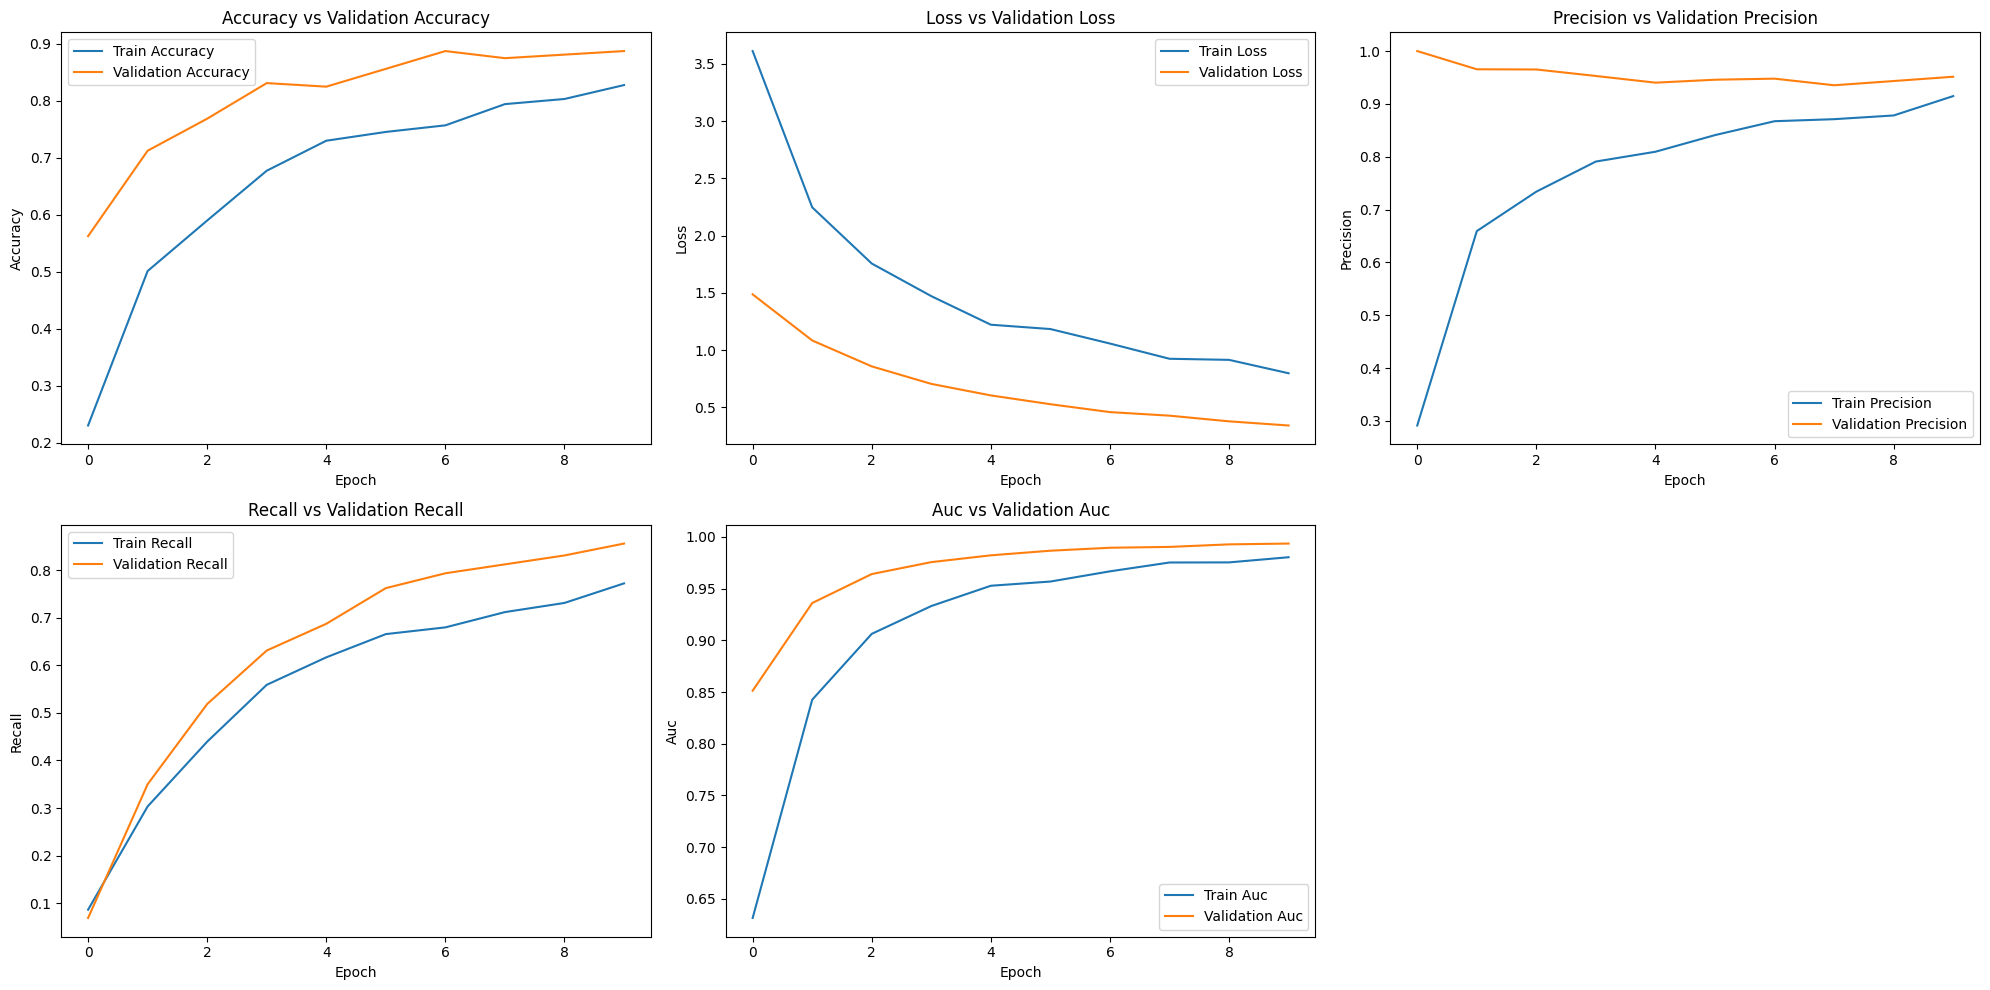

In [23]:
# Updated plot for training history
plt.figure(figsize=(20, 10))

# Plot Accuracy, Loss, Precision, Recall, AUC
metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.title(f'{metric.capitalize()} vs Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='best')

plt.tight_layout()
plt.show()
